In [ ]:
!gdown --id 12dG-TqDZz-BLEdlJydVfPSmhdIksjk5y

Downloading...
From: https://drive.google.com/uc?id=12dG-TqDZz-BLEdlJydVfPSmhdIksjk5y
To: /content/exp_demo_D_500000.pth
2.16MB [00:00, 68.1MB/s]


In [ ]:
# Pickle Model 
!gdown --id 1rRCQPDX0kFPqyJMfc-I-xXa9ly5FlX-L

Downloading...
From: https://drive.google.com/uc?id=1rRCQPDX0kFPqyJMfc-I-xXa9ly5FlX-L
To: /content/housegan_pickle.sav
2.17MB [00:00, 69.3MB/s]


In [ ]:
# HouseGAN
!git clone https://github.com/ennauata/housegan.git
# change directory
%cd housegan/
# graphviz is installed already, but need lib too
!apt install libgraphviz-dev
!pip install pygraphviz
# remove edges from nx.draw in variation_bbs_with_target_graph_segments_suppl draw graph line 72
!pip install webcolors
!pip install svgwrite
# Rename weights to exp_with_graph_global_new_D_200000.pth
!mv ../exp_demo_D_500000.pth ../exp_with_graph_global_new_D_200000.pth
!mkdir checkpoints
!mv ../exp_with_graph_global_new_D_200000.pth ./checkpoints
# !mv ../train_data.npy ./checkpoints
!mv ../housegan_pickle.sav ./housegan_pickle.sav


Cloning into 'housegan'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 145 (delta 12), reused 0 (delta 0), pack-reused 121
Receiving objects: 100% (145/145), 160.06 KiB | 5.00 MiB/s, done.
Resolving deltas: 100% (80/80), done.
/content/housegan
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 40 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bio

In [ ]:
import argparse
import os
import numpy as np
import math
import sys
import random
import pickle

import torchvision.transforms as transforms
from torchvision.utils import save_image

from floorplan_dataset_maps import FloorplanGraphDataset, floorplan_collate_fn
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch
from PIL import Image, ImageDraw
from reconstruct import reconstructFloorplan
import svgwrite
from utils import bb_to_img, bb_to_vec, bb_to_seg, mask_to_bb, remove_junctions, ID_COLOR, bb_to_im_fid
from models import Generator
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
import cv2
import webcolors

In [ ]:
def one_hot_encoding(nodes):
    length = 10
    ans = []
    for k in nodes:
        temp = [0 if i != ulta[k] else 1 for i in range(1, length+1)]
        ans.append(temp)
    return torch.Tensor(ans)
def process_edges(nodes, edges):
    prep_edgs = []
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if j > i:
                if [i, j] in edges or [j, i] in edges:
                    prep_edgs.append([i, 1, j])
                else:
                    prep_edgs.append([i, -1, j])
    return torch.tensor(prep_edgs, dtype=torch.int32)


# OLD
conversion = {1: 'living', 2: 'kitchen', 3: 'bedroom', 
              4: 'bathroom', 5:'closet', 6:'balcony', 7: 'corridor', 
              8: 'dining', 9: 'laundry', 10: 'unkown'}

# NEW
conversion = {1: 'living', 2: 'kitchen', 3: 'bedroom', 
              4: 'bathroom', 5:'unkown', 6:'closet', 7: 'balcony', 
              8: 'corridor', 9: 'dining', 10: 'laundry'}
ulta = {conversion[i]:i for i in conversion.keys()}



nodes = ['living',
         'bedroom',
         'bedroom',
         'bathroom',
         'bathroom',
         'balcony',
         'unkown',
         'dining'
]
edges = [
         [0],
         [0, 1],
         [0, 2],
         [0, 6],
         [0, 7],
         [1],
         [1, 0],
         [1, 3],
         [1, 5],
         [1,6],
         [2],
         [2, 0],
         [2, 4],
         [3],
         [3, 1],
         [4],
         [4, 2],
         [5],
         [5, 1],
         [6],
         [6, 0],
         [7],
         [7, 0],
          [7]
        #  [2, 3],
        #  [3, 2],
        #  [3, 1],
]
n, e = one_hot_encoding(nodes), process_edges(nodes, edges)

def custom_input(n, e):
    return n, e


def floorplan_collate_fn(nds,eds):
	all_rooms_mks, all_nodes, all_edges = [], [], []
	all_node_to_sample, all_edge_to_sample = [], []
	node_offset = 0
	for i, (nodes, edges) in enumerate(zip(nds,eds)):
		O, T = nodes.size(0), edges.size(0)
		# all_rooms_mks.append(rooms_mks)
		all_nodes.append(nodes)
		edges = edges.clone()
		if edges.shape[0] > 0:
			# edges[:, 0] += node_offset
			# edges[:, 2] += node_offset
			all_edges.append(edges)
		all_node_to_sample.append(torch.LongTensor(O).fill_(i))
		all_edge_to_sample.append(torch.LongTensor(T).fill_(i))
		node_offset += O
	# all_rooms_mks = torch.cat(all_rooms_mks, 0)
	all_nodes = torch.cat(all_nodes)
	if len(all_edges) > 0:
		all_edges = torch.cat(all_edges)
	else:
		all_edges = torch.tensor([])       
	all_node_to_sample = torch.cat(all_node_to_sample)
	all_edge_to_sample = torch.cat(all_edge_to_sample)
	return all_nodes, all_edges, all_node_to_sample, all_edge_to_sample


def pad_im(cr_im, final_size=256, bkg_color='white'):    
    new_size = int(np.max([np.max(list(cr_im.size)), final_size]))
    padded_im = Image.new('RGB', (new_size, new_size), 'white')
    padded_im.paste(cr_im, ((new_size-cr_im.size[0])//2, (new_size-cr_im.size[1])//2))
    padded_im = padded_im.resize((final_size, final_size), Image.ANTIALIAS)
    return padded_im

def draw_graph(g_true):
    # build true graph 
    G_true = nx.Graph()
    colors_H = []
    for k, label in enumerate(g_true[0]):
        _type = label+1 
        if _type >= 0:
            G_true.add_nodes_from([(k, {'label':_type})])
            colors_H.append(ID_COLOR[_type])
    for k, m, l in g_true[1]:
        if m > 0:
            G_true.add_edges_from([(k, l)], color='b',weight=4)    
    plt.figure()
    pos = nx.nx_agraph.graphviz_layout(G_true, prog='neato')

    edges = G_true.edges()
    colors = ['black' for u,v in edges]
    weights = [4 for u,v in edges]

    nx.draw(G_true, pos, node_size=1000, node_color=colors_H, font_size=0, font_weight='bold', edge_color=colors, width=weights)
    plt.tight_layout()
    plt.savefig('./dump/_true_graph.jpg', format="jpg")
    rgb_im = Image.open('./dump/_true_graph.jpg')
    rgb_arr = pad_im(rgb_im).convert('RGBA')
    return rgb_arr

        

def draw_masks(masks, real_nodes):

#     transp = Image.new('RGBA', img.size, (0,0,0,0))  # Temp drawing image.
#     draw = ImageDraw.Draw(transp, "RGBA")
#     draw.ellipse(xy, **kwargs)
#     # Alpha composite two images together and replace first with result.
#     img.paste(Image.alpha_composite(img, transp))
    
    bg_img = Image.new("RGBA", (256, 256), (255, 255, 255, 0))  # Semitransparent background.
    for m, nd in zip(masks, real_nodes):
        
        # draw region
        reg = Image.new('RGBA', (32, 32), (0,0,0,0))
        dr_reg = ImageDraw.Draw(reg)
        m[m>0] = 255
        m[m<0] = 0
        m = m.detach().cpu().numpy()
        m = Image.fromarray(m)
        color = ID_COLOR[nd+1]
        r, g, b = webcolors.name_to_rgb(color)
        dr_reg.bitmap((0, 0), m.convert('L'), fill=(r, g, b, 32))
        reg = reg.resize((256, 256))
        
        bg_img.paste(Image.alpha_composite(bg_img, reg))

  
    for m, nd in zip(masks, real_nodes):
        cnt = Image.new('RGBA', (256, 256), (0,0,0,0))
        dr_cnt = ImageDraw.Draw(cnt)
        
        mask = np.zeros((256,256,3)).astype('uint8')
        m[m>0] = 255
        m[m<0] = 0
        m = m.detach().cpu().numpy()[:, :, np.newaxis].astype('uint8')
        m = cv2.resize(m, (256, 256), interpolation = cv2.INTER_AREA) 
        ret,thresh = cv2.threshold(m,127,255,0)
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:  
            contours = [c for c in contours]
        color = ID_COLOR[nd+1]
        r, g, b = webcolors.name_to_rgb(color)
        cv2.drawContours(mask, contours, -1, (255, 255, 255), 2)
        
        mask = Image.fromarray(mask)
        dr_cnt.bitmap((0, 0), mask.convert('L'), fill=(r, g, b, 256))
        
        bg_img.paste(Image.alpha_composite(bg_img, cnt))
    
#     im2 = np.zeros((256,256,3)).astype('uint8') + 255
#     for m, nd in zip(masks, real_nodes):
#         m[m>0] = 255
#         m[m<0] = 0
#         m = m.detach().cpu().numpy()[:, :, np.newaxis].astype('uint8')
#         m = cv2.resize(m, (256, 256), interpolation = cv2.INTER_AREA) 
#         ret,thresh = cv2.threshold(m,127,255,0)
#         contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#         if len(contours) > 0:  
#             contours = [c for c in contours]
#         color = ID_COLOR[nd+1]
#         r, g, b = webcolors.name_to_rgb(color)

#         cv2.drawContours(im2, contours, -1, (r, g, b), 2)
#     im2 = Image.fromarray(im2).convert('RGBA')

#     im.paste(im2)
#     out.save('./test.png')
#     im.save('./test_reg.png')

    return bg_img

def draw_floorplan(dwg, junctions, juncs_on, lines_on):

    # draw edges
    for k, l in lines_on:
        x1, y1 = np.array(junctions[k])
        x2, y2 = np.array(junctions[l])
        #fill='rgb({},{},{})'.format(*(np.random.rand(3)*255).astype('int'))
        dwg.add(dwg.line((float(x1), float(y1)), (float(x2), float(y2)), stroke='black', stroke_width=4, opacity=1.0))

    # draw corners
    for j in juncs_on:
        x, y = np.array(junctions[j])
        dwg.add(dwg.circle(center=(float(x), float(y)), r=3, stroke='red', fill='white', stroke_width=2, opacity=1.0))
    return 


Namespace(batch_size=1, channels=1, exp_folder='exp', latent_dim=128, n_cpu=16, num_variations=8)


/usr/local/lib/python3.7/dist-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: b is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)
(256, 256, 4)


/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


CPU times: user 1.56 s, sys: 344 ms, total: 1.9 s
Wall time: 2.39 s


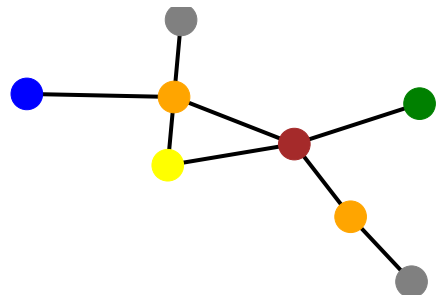

In [ ]:
%%time
parser = argparse.ArgumentParser()
parser.add_argument("--n_cpu", type=int, default=16, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=128, help="dimensionality of the latent space")
parser.add_argument("--batch_size", type=int, default=1, help="size of the batches")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--num_variations", type=int, default=8, help="number of variations")
parser.add_argument("--exp_folder", type=str, default='exp', help="destination folder")

opt = parser.parse_args("")
print(opt)
pickle_path = "./housegan_pickle.sav"
numb_iters = 200000
exp_name = 'exp_with_graph_global_new'
target_set = 'D'
phase='eval'
checkpoint = './checkpoints/{}_{}_{}.pth'.format(exp_name, target_set, numb_iters)
os.makedirs("./dump/", exist_ok=True)
os.makedirs("./output/", exist_ok=True)

def pad_im(cr_im, final_size=256, bkg_color='white'):    
    new_size = int(np.max([np.max(list(cr_im.size)), final_size]))
    padded_im = Image.new('RGB', (new_size, new_size), 'white')
    padded_im.paste(cr_im, ((new_size-cr_im.size[0])//2, (new_size-cr_im.size[1])//2))
    padded_im = padded_im.resize((final_size, final_size), Image.ANTIALIAS)
    return padded_im

def draw_graph(g_true):
    # build true graph 
    G_true = nx.Graph()
    colors_H = []
    for k, label in enumerate(g_true[0]):
        _type = label+1 
        if _type >= 0:
            G_true.add_nodes_from([(k, {'label':_type})])
            colors_H.append(ID_COLOR[_type])
    for k, m, l in g_true[1]:
        if m > 0:
            G_true.add_edges_from([(k, l)], color='b',weight=4)    
    plt.figure()
    pos = nx.nx_agraph.graphviz_layout(G_true, prog='neato')

    edges = G_true.edges()
    colors = ['black' for u,v in edges]
    weights = [4 for u,v in edges]

    nx.draw(G_true, pos, node_size=1000, node_color=colors_H, font_size=0, font_weight='bold', edge_color=colors, width=weights)
    plt.tight_layout()
    plt.savefig('./dump/_true_graph.jpg', format="jpg")
    rgb_im = Image.open('./dump/_true_graph.jpg')
    rgb_arr = pad_im(rgb_im).convert('RGBA')
    return rgb_arr

        
import cv2
import webcolors
def draw_masks(masks, real_nodes):

#     transp = Image.new('RGBA', img.size, (0,0,0,0))  # Temp drawing image.
#     draw = ImageDraw.Draw(transp, "RGBA")
#     draw.ellipse(xy, **kwargs)
#     # Alpha composite two images together and replace first with result.
#     img.paste(Image.alpha_composite(img, transp))
    
    bg_img = Image.new("RGBA", (256, 256), (255, 255, 255, 0))  # Semitransparent background.
    for m, nd in zip(masks, real_nodes):
        
        # draw region
        reg = Image.new('RGBA', (32, 32), (0,0,0,0))
        dr_reg = ImageDraw.Draw(reg)
        m[m>0] = 255
        m[m<0] = 0
        m = m.detach().cpu().numpy()
        m = Image.fromarray(m)
        color = ID_COLOR[nd+1]
        r, g, b = webcolors.name_to_rgb(color)
        dr_reg.bitmap((0, 0), m.convert('L'), fill=(r, g, b, 32))
        reg = reg.resize((256, 256))
        
        bg_img.paste(Image.alpha_composite(bg_img, reg))

  
    for m, nd in zip(masks, real_nodes):
        cnt = Image.new('RGBA', (256, 256), (0,0,0,0))
        dr_cnt = ImageDraw.Draw(cnt)
        
        mask = np.zeros((256,256,3)).astype('uint8')
        m[m>0] = 255
        m[m<0] = 0
        m = m.detach().cpu().numpy()[:, :, np.newaxis].astype('uint8')
        m = cv2.resize(m, (256, 256), interpolation = cv2.INTER_AREA) 
        ret,thresh = cv2.threshold(m,127,255,0)
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:  
            contours = [c for c in contours]
        color = ID_COLOR[nd+1]
        r, g, b = webcolors.name_to_rgb(color)
        cv2.drawContours(mask, contours, -1, (255, 255, 255), 2)
        
        mask = Image.fromarray(mask)
        dr_cnt.bitmap((0, 0), mask.convert('L'), fill=(r, g, b, 256))
        
        bg_img.paste(Image.alpha_composite(bg_img, cnt))
    
#     im2 = np.zeros((256,256,3)).astype('uint8') + 255
#     for m, nd in zip(masks, real_nodes):
#         m[m>0] = 255
#         m[m<0] = 0
#         m = m.detach().cpu().numpy()[:, :, np.newaxis].astype('uint8')
#         m = cv2.resize(m, (256, 256), interpolation = cv2.INTER_AREA) 
#         ret,thresh = cv2.threshold(m,127,255,0)
#         contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#         if len(contours) > 0:  
#             contours = [c for c in contours]
#         color = ID_COLOR[nd+1]
#         r, g, b = webcolors.name_to_rgb(color)

#         cv2.drawContours(im2, contours, -1, (r, g, b), 2)
#     im2 = Image.fromarray(im2).convert('RGBA')

#     im.paste(im2)
#     out.save('./test.png')
#     im.save('./test_reg.png')

    return bg_img

def draw_floorplan(dwg, junctions, juncs_on, lines_on):

    # draw edges
    for k, l in lines_on:
        x1, y1 = np.array(junctions[k])
        x2, y2 = np.array(junctions[l])
        #fill='rgb({},{},{})'.format(*(np.random.rand(3)*255).astype('int'))
        dwg.add(dwg.line((float(x1), float(y1)), (float(x2), float(y2)), stroke='black', stroke_width=4, opacity=1.0))

    # draw corners
    for j in juncs_on:
        x, y = np.array(junctions[j])
        dwg.add(dwg.circle(center=(float(x), float(y)), r=3, stroke='red', fill='white', stroke_width=2, opacity=1.0))
    return 

# Create folder
os.makedirs(opt.exp_folder, exist_ok=True)

# Initialize generator and discriminator
generator = Generator()
generator.load_state_dict(torch.load(checkpoint, map_location=torch.device('cpu')))

# Using pickle model
# load the model from disk
# generator = pickle.load(open(pickle_path, 'rb'))

# Generate Pickle file
# save the model to disk
import pickle
filename = 'housegan_pickle.sav'
pickle.dump(generator, open(filename, 'wb'))

# Initialize variables
cuda = True if torch.cuda.is_available() else False
# cuda = False 
if cuda:
    generator.cuda()
rooms_path = '/content/housegan/checkpoints/'

# Initialize dataset iterator
# fp_dataset_test = FloorplanGraphDataset(rooms_path, transforms.Normalize(mean=[0.5], std=[0.5]), target_set=target_set, split=phase)
# fp_loader = torch.utils.data.DataLoader(fp_dataset_test, 
#                                         batch_size=opt.batch_size, 
#                                         shuffle=False, collate_fn=floorplan_collate_fn)
# # Optimizers
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ------------
#  Vectorize
# ------------
globalIndex = 0
final_images = []
target_graph = list(range(500))
page_count = 0
n_rows = 0
# for i, batch in enumerate(fp_loader):
    # if i not in target_graph:
        # continue
        
    # Unpack batch
    # mks, nds, eds, nd_to_sample, ed_to_sample = batch
# print("real",nds, eds)
nds, eds = custom_input(n, e)
# print("custom",nds, eds)

#custom
# batch = (n,e)
# nds, eds, nd_to_sample, ed_to_sample = floorplan_collate_fn(batch)


# Configure input
# real_mks = Variable(mks.type(Tensor))
given_nds = Variable(nds.type(Tensor))
# print("real_mks:",real_mks.shape[0])
# print("given_nds:",given_nds.shape[0])
# break
given_eds = eds
for k in range(opt.num_variations):
#         print('var num {}'.format(k))
    # plot images
    z = Variable(Tensor(np.random.normal(0, 1, (given_nds.shape[0], opt.latent_dim))))
    with torch.no_grad():
        gen_mks = generator(z, given_nds, given_eds)
        gen_bbs = np.array([np.array(mask_to_bb(mk)) for mk in gen_mks.detach().cpu()])
        # real_bbs = np.array([np.array(mask_to_bb(mk)) for mk in real_mks.detach().cpu()])
        real_nodes = np.where(given_nds.detach().cpu()==1)[-1]
    gen_bbs = gen_bbs[np.newaxis, :, :]/32.0
    junctions = np.array(bb_to_vec(gen_bbs))[0, :, :]
    regions = np.array(bb_to_seg(gen_bbs))[0, :, :, :].transpose((1, 2, 0))
    graph = [real_nodes, None]
    
    if k == 0:
        graph_arr = draw_graph([real_nodes, eds.detach().cpu().numpy()])
        final_images.append(graph_arr)
        
#             # place real 
#             real_bbs = real_bbs[np.newaxis, :, :]/32.0
#             real_im = bb_to_im_fid(real_bbs, real_nodes)
#             final_images.append(real_im)
        
        
    # reconstruct
    fake_im_seg = draw_masks(gen_mks, real_nodes)
    final_images.append(fake_im_seg)
    fake_im_bb = bb_to_im_fid(gen_bbs, real_nodes, im_size=256).convert('RGBA')
    final_images.append(fake_im_bb)
n_rows += 1
# if (n_rows+1)%12 == 0: 
final_images_new = []
for im in final_images:
    print(np.array(im).shape)
    final_images_new.append(torch.tensor(np.array(im).transpose((2, 0, 1)))/255.0)

# print('final: ', final_images_new[0].shape)
final_images = final_images_new
final_images = torch.stack(final_images)
# print(final_images)
save_image(final_images, "./output/results_page_{}_{}.png".format(target_set, page_count), nrow=2*opt.num_variations+1, padding=2, range=(0, 1), pad_value=0.5, normalize=False)
page_count += 1
n_rows = 0
final_images = []

# break


/usr/local/lib/python3.7/dist-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: b is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


(256, 256, 4) 0
(256, 256, 4) 1
(256, 256, 4) 2
(256, 256, 4) 3
(256, 256, 4) 4
(256, 256, 4) 5
(256, 256, 4) 6
(256, 256, 4) 7
(256, 256, 4) 8
(256, 256, 4) 9
(256, 256, 4) 10
(256, 256, 4) 11
(256, 256, 4) 12
(256, 256, 4) 13
(256, 256, 4) 14
(256, 256, 4) 15
(256, 256, 4) 16
(256, 256, 4) 17
(256, 256, 4) 18
(256, 256, 4) 19


/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  assert isinstance(range, tuple), \


(256, 256, 4) 20
CPU times: user 2.2 s, sys: 171 ms, total: 2.37 s
Wall time: 2.27 s


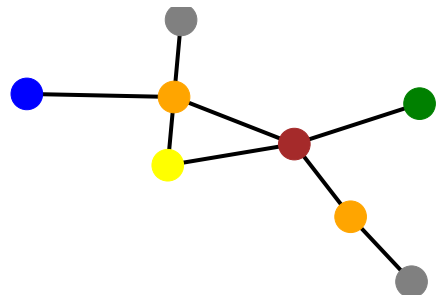

In [ ]:
%%time

exp_folder = 'exp'
num_variations = 10
channels = 1
batch_size = 1
latent_dim = 128
n_cpu = 16

# print(opt)
pickle_path = "./housegan_pickle.sav"
target_set = 'D'
os.makedirs("./dump/", exist_ok=True)
os.makedirs("./output/", exist_ok=True)


# Create folder
os.makedirs(exp_folder, exist_ok=True)

generator = pickle.load(open(pickle_path, 'rb'))

# Initialize variables
cuda = True if torch.cuda.is_available() else False
# cuda = False 
if cuda:
    generator.cuda()


# # Optimizers
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ------------
#  Vectorize
# ------------
globalIndex = 0
final_images = []
target_graph = list(range(500))
page_count = 0
n_rows = 0

nds, eds = custom_input(n, e)

given_nds = Variable(nds.type(Tensor))

given_eds = eds
for k in range(num_variations):
    # plot images
    z = Variable(Tensor(np.random.normal(0, 1, (given_nds.shape[0], latent_dim))))
    with torch.no_grad():
        gen_mks = generator(z, given_nds, given_eds)
        gen_bbs = np.array([np.array(mask_to_bb(mk)) for mk in gen_mks.detach().cpu()])
        real_nodes = np.where(given_nds.detach().cpu()==1)[-1]
    gen_bbs = gen_bbs[np.newaxis, :, :]/32.0
    junctions = np.array(bb_to_vec(gen_bbs))[0, :, :]
    regions = np.array(bb_to_seg(gen_bbs))[0, :, :, :].transpose((1, 2, 0))
    graph = [real_nodes, None]
    
    if k == 0:
        graph_arr = draw_graph([real_nodes, eds.detach().cpu().numpy()])
        final_images.append(graph_arr)
        
      
        
    # reconstruct
    fake_im_seg = draw_masks(gen_mks, real_nodes)
    final_images.append(fake_im_seg)
    fake_im_bb = bb_to_im_fid(gen_bbs, real_nodes, im_size=256).convert('RGBA')
    final_images.append(fake_im_bb)
n_rows += 1
# if (n_rows+1)%12 == 0: 
final_images_new = []
img_to_save = []
for idx, im in enumerate(final_images):
    print(np.array(im).shape, idx)
    if idx!=0:
        img_to_save.append(torch.tensor(np.array(im).transpose((2, 0, 1)))/255.0)
    final_images_new.append(torch.tensor(np.array(im).transpose((2, 0, 1)))/255.0)

    # if idx!=0 and idx%2==0:
    #     img_to_save = torch.stack(img_to_save)
    #     save_image(img_to_save, "./output/results_page_{}_{}.png".format(target_set, page_count+idx), 
    #         nrow=2*num_variations+1, padding=2, range=(0, 1), pad_value=0.5, normalize=False)
    #     img_to_save = []
    to_save = torch.tensor(np.array(im).transpose((2, 0, 1)))/255.0
    save_image(to_save, "./output/plan{}_{}.png".format(target_set, page_count+idx), 
            nrow=2*num_variations+1, padding=2, range=(0, 1), pad_value=0.5, normalize=False)

# print('final: ', final_images_new[0].shape)
final_images = final_images_new
final_images = torch.stack(final_images)
# print(final_images)
save_image(final_images, "./output/plan{}_{}.png".format(target_set, page_count), 
           nrow=2*num_variations+1, padding=2, range=(0, 1), pad_value=0.5, normalize=False)
page_count += 1
n_rows = 0
final_images = []



In [ ]:
!rm -r ./output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Flask Server

# Flask

In [1]:
!git clone -b housegan_server https://github.com/tejasbana/floorPlan.git
%cd floorPlan/

Cloning into 'floorPlan'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 156 (delta 80), reused 97 (delta 36), pack-reused 0
Receiving objects: 100% (156/156), 219.36 KiB | 6.09 MiB/s, done.
Resolving deltas: 100% (80/80), done.
/content/floorPlan


In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=16w4uifjVvuK8xKYcKwrXRNmAEhqKRL2I' -O ./firebase_cre.json

In [ ]:
!pip install -r ./requirements.txt

In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz

In [5]:
!pip install flask_ngrok

In [ ]:
!sudo pip install firebase-admin
!pip install image_registration

In [7]:
# !pip install pyrebase
!gdown --id 16w4uifjVvuK8xKYcKwrXRNmAEhqKRL2I

Downloading...
From: https://drive.google.com/uc?id=16w4uifjVvuK8xKYcKwrXRNmAEhqKRL2I
To: /content/floorPlan/firebase_cre.json
100% 2.34k/2.34k [00:00<00:00, 1.82MB/s]


In [ ]:
!python3 firebase_server.py

In [ ]:
!flask_uploads --version

/bin/bash: flask_uploads: command not found


In [ ]:
!python3 server.py

In [ ]:
https://stackoverflow.com/questions/15661384/python-does-not-see-pygraphviz
https://stackoverflow.com/questions/15661384/python-does-not-see-pygraphviz

# Flask Fetch  Image

In [ ]:
!pip install image_registration

In [29]:
import scipy as sp 
print(sp.__version__)

1.7.1


In [ ]:
# !python colab_boundary_server.py
!python server.py

In [ ]:
context = ('./server.crt', './server.key')# app.run(debug=True, use_reloader=True, threaded=True)
#app.run(host="0.0.0.0", port=5000,debug=True,  ssl_context=context)
app.run(debug=True)

In [21]:
final_list

[12, 12, 5, 5, 3]